In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 

# Expectation Maximization  

We explore the EM algorithm on the two component Gaussian mixture model. First, we create two arrays of random variables from two different Gaussian distributions.

In [9]:
data_1 = np.random.normal(0,3,1000)
data_2 = np.random.normal(5,5,1000)
df = pd.DataFrame({'dist_one':data_1, 'dist_two':data_2})
df.head()

,dist_one,dist_two
0,2.338146,18.502962
1,0.765936,8.877234
2,-0.909563,2.002706
3,-1.152446,-1.987892
4,3.450079,6.710194


If we knew the data a priori, we could easily distinguish between the two distributions like so...

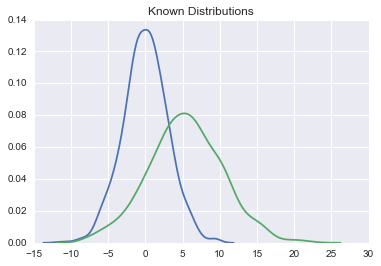

In [10]:
sns.kdeplot(df['dist_one'].values)
sns.kdeplot(df['dist_two'].values)
plt.title('Known Distributions')
plt.show();

But in the real world the data would actually look like this...

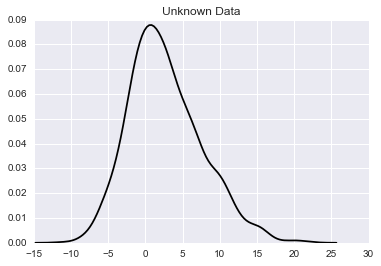

In [11]:
d = np.hstack([data_1, data_2])
sns.kdeplot(d, color='k')
plt.title('Unknown Data');

Let's say we see the data above and have some domain knowledge that leads us to believe there are two underlying processes, each with their own distribution. We are interested in finding 

$y = \alpha \cdot N(\mu_1,\sigma_1) + (1 - \alpha) \cdot N(\mu_2,\sigma_2)$

where $\alpha$ is the probability $y$ is from the first Gaussian distribution.

To begin the process, we need to initialize all of the parameters. We set $\mu_1$ and $\mu_2$ as random points from our training data, $\sigma_1$ and $\sigma_2$ as the standard deviation of the training data, and $\alpha$ as 50%. This is based on the recommendation of Tibshirani et al. in *The Elements of Statistical Learning*.

In [12]:
mu1 = np.random.choice(d, 1)
mu2 = np.random.choice(d, 1)
sigma1 = np.std(d)
sigma2 = np.std(d)
alpha1 = 0.5
alpha2 = 1 - alpha1
N = len(d)

Now we run through our algorithm. The expectation step calculates the "responsibility" of the given distribution for each data point. Or more formally, we will develop a weight vector, $w_k$, for each of our Gaussian distributions using our input vector $\bf{x}$.  

$$w_k=\frac{\alpha_k \cdot \phi_k(\bf{x})}{\sum_{i} \alpha_k \cdot \phi_k(\bf{x})} \textrm{ where k}\in (1,2),$$

In the maximization step, we update $\alpha$ based on the proportion of weights and update $\mu$ and $\sigma$ based on a weighted average.

$$\alpha_k = \frac{\sum w_k}{N}$$

$$\mu_k^* = \frac{\bf{w_k} \cdot \bf{x}}{\sum w_k}$$

$$\sigma_k^* = \sqrt{\frac{\bf{w_k} \cdot \bf{(x-\mu_k)^2}}{\sum w_k}}$$

We repeat the expecation and maximization steps until convergence. In this example, we define convergence based on the log-likelihood change.

$$ l(\theta) = \sum_{i=1}^{N} log[\alpha_1 \cdot \phi_1(x_i) + \alpha_2 \cdot \phi_2(x_i)]$$ 


In [13]:
i = 0
max_iterations = 1000
tolerance = 0.00000001

log_likelihood = sum(np.log(alpha1 * scipy.stats.norm(mu1,sigma1).pdf(d) + alpha2 * scipy.stats.norm(mu2,sigma2).pdf(d)))

while i < max_iterations:
    #Expectation Step
    one = alpha1 * scipy.stats.norm(mu1,sigma1).pdf(d)
    two = alpha2 * scipy.stats.norm(mu2,sigma2).pdf(d)
    w1 = one / (one + two)
    w2 = two / (one + two)
    
    #Maximization Step
    alpha1 = sum(w1) / N
    alpha2 = 1 - alpha1
    mu1 = np.dot(w1, d) / sum(w1)
    mu2 = np.dot(w2, d) / sum(w2)
    sigma1 = np.sqrt(np.dot(w1,(d-mu1)**2)/ sum(w1))
    sigma2 = np.sqrt(np.dot(w2,(d-mu2)**2)/ sum(w2))
    i += 1
    
    #Loglikelihood Check
    new_likelihood = sum(np.log(alpha1 * scipy.stats.norm(mu1,sigma1).pdf(d) + alpha2 * scipy.stats.norm(mu2,sigma2).pdf(d)))
    if abs(log_likelihood - new_likelihood) < tolerance:
        break
    else:
        log_likelihood = new_likelihood
    
print "After %d iterations, EM found: " % i
print "Distribution 1: Mean: %f Standard Deviation: %f" % (mu1, sigma1)
print "Distribution 2: Mean: %f Standard Deviation: %f" % (mu2, sigma2)

After 284 iterations, EM found: 
Distribution 1: Mean: 5.417460 Standard Deviation: 5.064818
Distribution 2: Mean: 0.198326 Standard Deviation: 3.109508


Which is pretty close to our original distributions of $N(0,3) \textrm{ and } N(5,5)$. 